In [1]:
def griddata_inter(X1,X2,X3,point,xi,yi,Water,Aot,Raa):
    X1_new_inter=[]
    X2_new_inter=[]
    X3_new_inter=[]

    X1_inter=X1[Water,Aot,:,:,Raa].reshape(17*17,1)
    X2_inter=X2[Water,Aot,:,:,Raa].reshape(17*17,1)
    X3_inter=X3[Water,Aot,:,:,Raa].reshape(17*17,1)

    X1_new = griddata(point, X1_inter, (xi, yi), method='cubic')
    X2_new = griddata(point, X2_inter, (xi, yi), method='cubic')
    X3_new = griddata(point, X3_inter, (xi, yi), method='nearest')

    X1_new_inter.append(X1_new)
    X2_new_inter.append(X2_new)
    X3_new_inter.append(X3_new)

    del X1_inter,X2_inter,X3_inter,X1_new,X2_new,X3_new  
    return X1_new_inter,X2_new_inter,X3_new_inter

class LUT_interpolation:
    def __init__(self,LUT_path):
        self.LUT_path = LUT_path
    
    def LUT_interpolation(self):
#         Continental_X1 = np.loadtxt(self.LUT_path + "Continental_01_band3.csv",delimiter=",").reshape(8,5,12,17,17,19)
#         Continental_X2 = np.loadtxt(self.LUT_path + "Continental_02_band3.csv",delimiter=",").reshape(8,5,12,17,17,19)
#         Continental_X3 = np.loadtxt(self.LUT_path + "Continental_03_band3.csv",delimiter=",").reshape(8,5,12,17,17,19)
        
        X1 = np.loadtxt(self.LUT_path + "Maritime_01_band6.csv",delimiter=",").reshape(8,12,17,17,19)
        X2 = np.loadtxt(self.LUT_path + "Maritime_02_band6.csv",delimiter=",").reshape(8,12,17,17,19)
        X3 = np.loadtxt(self.LUT_path + "Maritime_03_band6.csv",delimiter=",").reshape(8,12,17,17,19)

        
#         del Continental_X1,Maritime_X1,Continental_X2,Maritime_X2,Continental_X3,Maritime_X3
        

        
        point = np.array(np.meshgrid(sza, vza)).T.reshape(-1,2)
        xi,yi=np.ogrid[0:80:161j, 0:80:161j]
        output = Parallel(n_jobs=-1)(delayed(griddata_inter)(X1,X2,X3,point,xi,yi,Water,Aot,Raa)\
                                         for Water in range(len(water))                              
                                         for Aot in range(len(AOT))                              
                                         for Raa in range(len(raa)))

        X1_new_inter_reshape=np.array(output)[:,0].reshape(8,12,19,161,161)
        X2_new_inter_reshape=np.array(output)[:,1].reshape(8,12,19,161,161)
        X3_new_inter_reshape=np.array(output)[:,2].reshape(8,12,19,161,161)

        del X1,X2,X3,output

        sza_new = np.linspace(0,80,161)
        vza_new = np.linspace(0,80,161)

        fn1 = RegularGridInterpolator((water,AOT,raa,sza_new,vza_new),X1_new_inter_reshape,bounds_error=False,fill_value=np.nan)
        fn2 = RegularGridInterpolator((water,AOT,raa,sza_new,vza_new),X2_new_inter_reshape,bounds_error=False,fill_value=np.nan)
        fn3 = RegularGridInterpolator((water,AOT,raa,sza_new,vza_new),X3_new_inter_reshape,bounds_error=False,fill_value=np.nan)

        return fn1,fn2,fn3

In [2]:
import numpy as np
from Py6S import *
import time as T
from joblib import Parallel, delayed
from scipy.interpolate import griddata,interpn,RegularGridInterpolator
import math
import os
import datetime
import cv2
from ftplib import FTP
import rioxarray
import xarray as xr
import multiprocessing
import paramiko
from scp import SCPClient
import subprocess

In [3]:
sza = np.linspace(0,80,17)
vza = np.linspace(0,80,17)
water = np.linspace(0,7,8)
ozone = np.linspace(0.2,0.4,5)
AOT = np.array([0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0])
raa = np.linspace(0,180,19)
LUT_path = '/media/liwei/Data/LUT/'

In [4]:
fn1,fn2,fn3 = LUT_interpolation(LUT_path).LUT_interpolation()

In [5]:
OZONE = np.random.uniform(0.2,0.4,1000)
WATER = np.random.uniform(0,7,1000)
AOT = np.random.uniform(0.01,2,1000)
SZA = np.random.uniform(0,80,1000)
VZA = np.random.uniform(0,80,1000)
RAA = np.random.uniform(0,180,1000)


In [6]:
xa_LUT = []
xb_LUT = []
xc_LUT = []

for i in range(1000):
    xi = np.array([WATER[i],AOT[i],RAA[i],SZA[i],VZA[i]])
    xi = xi.T
    xa_LUT.append(fn1(xi))
    xb_LUT.append(fn2(xi))
    xc_LUT.append(fn3(xi))
    
xa_LUT = np.array(xa_LUT)
xb_LUT = np.array(xb_LUT)
xc_LUT = np.array(xc_LUT)

In [7]:

def sixS(i):
    s = SixS()
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(WATER[i],0.3)
    s.aero_profile = AeroProfile.PredefinedType(2)
    s.aot550 = AOT[i]
    s.wavelength = Wavelength(band[0,0],band[band.shape[0]-1,0],band[:,1])
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(0)
    s.geometry = Geometry.User()
    s.geometry.solar_z = SZA[i]
    s.geometry.solar_a = RAA[i]
    s.geometry.view_z = VZA[i]
    s.geometry.view_a = 0
    
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(0.2)
    s.run()
    
    
    f1 = 1/(s.outputs.transmittance_total_scattering.total*s.outputs.transmittance_global_gas.total)
    return(f1, s.outputs.coef_xb, s.outputs.coef_xc)

In [8]:
wl_band = "/media/liwei/Data/6S_band/sixs_band6.csv"
band = np.loadtxt(wl_band,delimiter=",")
AC_output = Parallel(n_jobs=-1)(delayed(sixS)(i) \
                                for i in range (1000))

In [9]:
X=np.array(AC_output)
X1=X[:,0]
X2=X[:,1]
X3=X[:,2]

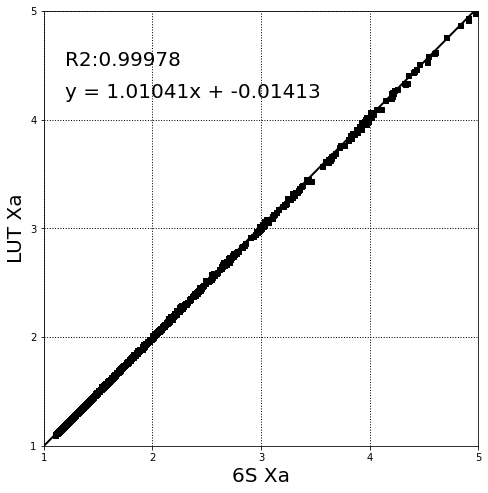

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

x = np.arange(1,6) 
y =  1  * x 
r2 = r2_score(X1, xa_LUT)
r2 = np.around(r2,5)

k = np.polyfit(X1, xa_LUT,1)[0][0]
b = np.polyfit(X1, xa_LUT,1)[1][0]
k = np.around(k,5)
b = np.around(b,5)
xx = np.arange(1,6) 
yy = k * xx + b


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(x,y,color='r',linewidth=5,linestyle='-',zorder=2)
ax.plot(xx,yy,color='k',linewidth=2,linestyle='-',zorder=2)


ax.scatter(X1, xa_LUT,marker='s',s=25,c='k')
ax.set_xticks(np.arange(1,6,1))
ax.set_yticks(np.arange(1,6,1))
ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xa",fontsize=20)
ax.set_ylabel("LUT Xa",fontsize=20)
ax.text(1.2,4.5,s = 'R2:{}'.format(r2),fontsize=20)
ax.text(1.2,4.2,s = 'y = {}x + {}'.format(k,b),fontsize=20)
plt.xlim(1,5)
plt.ylim(1,5)
plt.show()
fig.savefig('LUT_xa_B06.jpg',dpi = 1000,bbox_inches = 'tight')

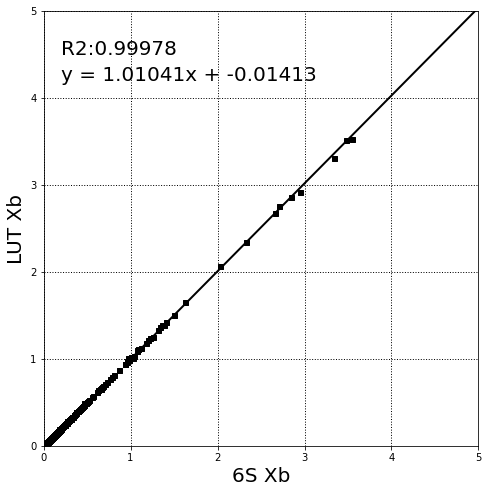

In [11]:
x = np.arange(1,6) 
y =  1  * x 
r2 = r2_score(X1, xa_LUT)
r2 = np.around(r2,5)

k = np.polyfit(X1, xa_LUT,1)[0][0]
b = np.polyfit(X1, xa_LUT,1)[1][0]
k = np.around(k,5)
b = np.around(b,5)
xx = np.arange(1,6) 
yy = k * xx + b


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(x,y,color='r',linewidth=5,linestyle='-',zorder=2)
ax.plot(xx,yy,color='k',linewidth=2,linestyle='-',zorder=2)


ax.scatter(X2, xb_LUT,marker='s',s=25,c='k')
ax.set_xticks(np.arange(0,6,1))
ax.set_yticks(np.arange(0,6,1))
ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xb",fontsize=20)
ax.set_ylabel("LUT Xb",fontsize=20)
ax.text(0.2,4.5,s = 'R2:{}'.format(r2),fontsize=20)
ax.text(0.2,4.2,s = 'y = {}x + {}'.format(k,b),fontsize=20)
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()
fig.savefig('LUT_xb_B06.jpg',dpi = 1000,bbox_inches = 'tight')

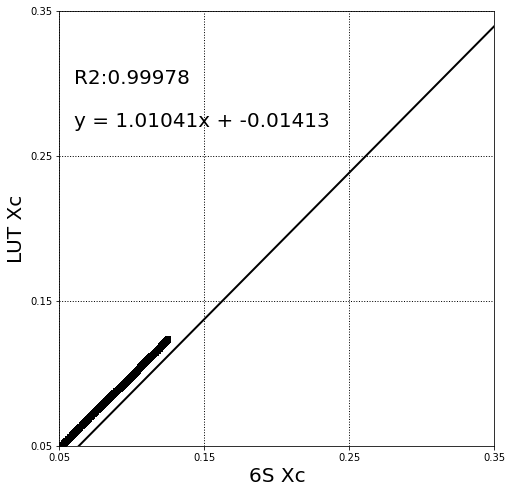

In [12]:
x = np.arange(0.05,0.35,0.1)
y =  1  * x 
r2 = r2_score(X1, xa_LUT)
r2 = np.around(r2,5)

k = np.polyfit(X1, xa_LUT,1)[0][0]
b = np.polyfit(X1, xa_LUT,1)[1][0]
k = np.around(k,5)
b = np.around(b,5)
xx = np.arange(0.05,0.4,0.1) 
yy = k * xx + b


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')

# ax.plot(x,y,color='r',linewidth=5,linestyle='-',zorder=2)
ax.plot(xx,yy,color='k',linewidth=2,linestyle='-',zorder=2)


ax.scatter(X3, xc_LUT,marker='s',s=25,c='k')
ax.set_xticks(np.arange(0.05,0.36,0.1))
ax.set_yticks(np.arange(0.05,0.36,0.1))
ax.grid(color='k', linestyle='dotted', linewidth=1,which='both')
ax.set_xlabel("6S Xc",fontsize=20)
ax.set_ylabel("LUT Xc",fontsize=20)
ax.text(0.06,0.3,s = 'R2:{}'.format(r2),fontsize=20)
ax.text(0.06,0.27,s = 'y = {}x + {}'.format(k,b),fontsize=20)
plt.xlim(0.05,0.35)
plt.ylim(0.05,0.35)
plt.show()
fig.savefig('LUT_xc_B06.jpg',dpi = 1000,bbox_inches = 'tight')